

## Experiment Details
__Experiment Id__ : 006 \
__Target__ : Test the model performance on the hand-written razor images \
__Solution__ : 
- create MNIST sticker set
- train and test model on mnist dataset

__Empirical result__ : 
- model size be even smaller [9574]
- get to very high accuracy
- shows clean outputs in the inference time

In [ ]:
! pip install tensorflow-model-optimization

---
Implementation

In [24]:
import os 
import math
import pandas as pd 
import numpy as np
from skimage import io, transform 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow_datasets as tfds
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import losses
import tensorflow_model_optimization as tfmot

from tcn import TCN

import neptune.new as neptune

In [3]:
%load_ext tensorboard

---
Set global variables

In [4]:
gpu_available = tf.config.list_physical_devices('GPU')
gpu_available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
IMAGE_SIZE = (128,48)
DATA_BS = 10
DATA_N = 10
LR = 0.005
EPOCHS = 10
BS = 32

---
Dataset & Dataloader 

In [6]:
(ds_train, ds_test), info = tfds.load('mnist', split=['train', 'test'], with_info=True)
train_gen = tfds.as_numpy(ds_train)
test_gen = tfds.as_numpy(ds_test)

Load dataset info from ~\tensorflow_datasets\mnist\3.0.1
Reusing dataset mnist (~\tensorflow_datasets\mnist\3.0.1)
Constructing tf.data.Dataset mnist for split ['train', 'test'], from ~\tensorflow_datasets\mnist\3.0.1


In [7]:
class MNISTDataset(object):

    def __init__(self, n_digits=8, image_size=(156, 32)):
        self.n_digits = n_digits
        self.image_size = image_size

    def gen_data(self, gen):
        images, labels = [], []
        for x in gen:
            images.append(x['image'])
            labels.append(x['label'])
        images, labels = np.squeeze(np.array(images)), np.squeeze(np.array(labels)); print(images.shape,labels.shape,labels)
        return images, labels

    def gen_patch(self, img, ann, c=np.inf):
        size = img.shape[0]
        indexes = np.arange(size)
        np.random.shuffle(indexes)
        
        c_prime = divmod(size, self.n_digits)[0]*self.n_digits
        if c_prime < c:
            size = c_prime
        else:
            size = divmod(c, self.n_digits)[0]*self.n_digits

        sample_index = indexes[:size]
        sticker_index = sample_index.reshape((-1, self.n_digits)).T
        sticker_images = np.transpose(np.hstack([np.transpose(img[inds], (0, 2, 1)) for inds in sticker_index]), (0, 2, 1))
        sfl_label =  ann[sample_index, ...]
        sticker_labels = sfl_label.reshape((-1, self.n_digits))
        return sticker_images, sticker_labels

    def generate(self, data_generator, n_sample):
        init_image, init_label = self.gen_data(data_generator)
        c = n_sample
        dt_images, dt_labels = self.gen_patch(init_image, init_label, c)
        while c > self.n_digits:
            c = n_sample - dt_images.shape[0]
            p_images, p_labels = self.gen_patch(init_image, init_label, c)
            dt_images, dt_labels = np.vstack((dt_images, p_images)), np.vstack((dt_labels, p_labels))

        ret_tensor = tf.convert_to_tensor(np.swapaxes(dt_images, 1, 2), dtype=tf.float32);print(dt_images.shape,dt_labels.shape)
        ind_tensor = tf.convert_to_tensor(dt_labels, dtype=tf.int32)
        dataset = tf.data.Dataset.from_tensor_slices((ret_tensor, ind_tensor))
        return dataset

In [8]:
mnist = MNISTDataset()

In [10]:
train_dataset = mnist.generate(train_gen, n_sample=10000)
test_dataset = mnist.generate(test_gen, n_sample=2000)

(60000, 28, 28) (60000,) [4 1 0 ... 6 1 5]
(9993, 28, 224) (9993, 8)
(10000, 28, 28) (10000,) [2 0 4 ... 8 0 5]
(1993, 28, 224) (1993, 8)


(224, 28)
[4 6 8 7 8 3 7 4]


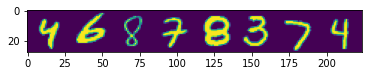

In [11]:
for i in test_dataset.take(1):
    img, label = i
print(img.shape)
print(label.numpy())
plt.imshow(img.numpy().T)
IMAGE_SIZE = img.shape

In [12]:
train_loader = train_dataset.shuffle(buffer_size=1000).batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_loader = test_dataset.batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

---
Model Defining

In [27]:
class RecNet(tf.keras.Model):
	def __init__(self, bs=16, input_size=(128, 48), n_classes=10, h_cell=64, max_obj=15, linear_k=3, latent_size=32, rho=0.05):
		super().__init__()
		self.bs = bs
		self.rho = rho
		self.input_size = input_size
		self.n_classes = n_classes  # LSTM module projection size
		self.h_cell = h_cell  # LSTM hidden size
		self.max_obj = max_obj
		self.linear_k = linear_k
		self.latent_size = latent_size
		self.model = self.build_model(
			self.input_size, self.h_cell, self.n_classes, self.max_obj, self.latent_size, self.linear_k)

		self.scce = losses.SparseCategoricalCrossentropy(from_logits=False,)

		self.loss_metric = tf.keras.metrics.Mean(name="loss")
		self.acc_metric = tf.keras.metrics.Mean(name="accuracy")
		self.acc_mat = tf.keras.metrics.Accuracy()


	def build_model(self, input_shape=(128, 48), h_cell=32, n_classes=10, n_obj=10, latent_size=32, linear_k=3):
		forward_layer = layers.LSTM(h_cell//2, return_sequences=True)
		model = tf.keras.Sequential([
			layers.Input(shape=input_shape, name='input_layer'),
			layers.LSTM(latent_size, activation='tanh',
						return_sequences=True, go_backwards=True),
			layers.Conv1D(n_classes, linear_k, activation='tanh', name='projection_encoder'),
			layers.Permute((2, 1)),
			layers.Conv1D(n_obj, 1, activation='tanh'),
			layers.Permute((2, 1)),
			layers.Activation('softmax')
		])

		return model


	@property
	def metrics(self):
		return [self.loss_metric, self.acc_mat]

	def calculate_loss(self, target, pred):
		target = tf.reshape(target, shape=(-1))
		pred = tf.reshape(pred, shape=(-1, self.n_classes))
		loss = self.scce(target, pred)

		y_hat = tf.argmax(pred, axis=-1)
		acc = self.acc_mat(y_hat, target)
		return loss, acc

	def call(self, x):
		full_out = self.model(x)
		return full_out

	def train_step(self, batch_data):
		x, target = batch_data
		e_ws = []
		with tf.GradientTape() as tape:
			pred = self(x, training=True)
			# print(pred.shape, pred)
			loss, acc = self.calculate_loss(target, pred)

		trainable_params = self.trainable_variables
		gradients = tape.gradient(loss, trainable_params)
		grad_norm = self._grad_norm(gradients)
		scale = self.rho / (grad_norm + 1e-12)

		for (grad, param) in zip(gradients, trainable_params):
			e_w = grad*scale 
			param.assign_add(e_w)
			e_ws.append(e_w)

		with tf.GradientTape() as tape:
			pred = self(x, training=True)
			loss, acc = self.calculate_loss(target, pred)

		sam_gradient = tape.gradient(loss, trainable_params)
		for (param, e_w) in zip(trainable_params, e_ws):
			param.assign_sub(e_w)

		self.optimizer.apply_gradients(zip(sam_gradient, trainable_params))
		self.loss_metric.update_state(loss)
		self.acc_metric.update_state(acc)
		return {
			"loss": self.loss_metric.result(),
			"accuracy": self.acc_mat.result(),
		}

	def test_step(self, batch_data):
		x, target = batch_data

		pred = self(x, training=False)
		loss, acc = self.calculate_loss(target, pred)

		self.loss_metric.update_state(loss)
		self.acc_metric.update_state(acc)
		return {
			"loss": self.loss_metric.result(),
			"accuracy": self.acc_mat.result(),
		}

	def _grad_norm(self, gradients):
		norm = tf.norm(
			tf.stack([
				tf.norm(grad) for grad in gradients if grad is not None
			])
		)
		return norm


In [28]:
recNet = RecNet(input_size=IMAGE_SIZE,
                bs=BS,
                n_classes=10,
                h_cell=64,
                max_obj=8,
                linear_k=3)

In [29]:
recNet.model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 224, 32)           7808      
                                                                 
 projection_encoder (Conv1D)  (None, 222, 10)          970       
                                                                 
 permute_4 (Permute)         (None, 10, 222)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 8)             1784      
                                                                 
 permute_5 (Permute)         (None, 8, 10)             0         
                                                                 
 activation_2 (Activation)   (None, 8, 10)             0         
                                                                 
Total params: 10,562
Trainable params: 10,562
Non-trai

---
Set up model training details

In [16]:
def lr_time_based_decay(epoch, lr):
    decay = 0.001
    return lr * 1 / (1 + decay * epoch)

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return LR * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return LR * math.exp(-k*epoch)

decay_steps = 1000
# lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
#     LR, decay_steps)

lr_decaying_callback = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)

In [17]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=0,
                            patience=2,
                            restore_best_weights=True
                        )

In [18]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
)

In [19]:
# model = RecNet(bs=BS)
model = RecNet(input_size=IMAGE_SIZE,
                bs=BS,
                n_classes=10,
                h_cell=64,
                max_obj=8,
                linear_k=3)
model.compile(optimizer, loss='categorical_crossentropy', run_eagerly=True)

In [20]:
model.model.layers

In [21]:
model.fit(
    train_loader,
    epochs=EPOCHS,
    validation_data=valid_loader,
    callbacks=[earlystopping_callback,
               lr_decaying_callback]
)
# run.stop()


Epoch 00001: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/10
312/312 [==============================] - 49s 127ms/step - loss: 1.1171 - accuracy: 0.8318 - val_loss: 0.8984 - val_accuracy: 0.9439 - lr: 0.0050

Epoch 00002: LearningRateScheduler setting learning rate to 0.005.
Epoch 2/10
312/312 [==============================] - 44s 141ms/step - loss: 0.9101 - accuracy: 0.9421 - val_loss: 0.8866 - val_accuracy: 0.9490 - lr: 0.0050

Epoch 00003: LearningRateScheduler setting learning rate to 0.005.
Epoch 3/10
312/312 [==============================] - 46s 147ms/step - loss: 0.8935 - accuracy: 0.9497 - val_loss: 0.8766 - val_accuracy: 0.9536 - lr: 0.0050

Epoch 00004: LearningRateScheduler setting learning rate to 0.005.
Epoch 4/10
312/312 [==============================] - 45s 143ms/step - loss: 0.8838 - accuracy: 0.9547 - val_loss: 0.8697 - val_accuracy: 0.9557 - lr: 0.0050

Epoch 00005: LearningRateScheduler setting learning rate to 0.005.
Epoch 5/10
312/312 [========

In [22]:
# save model before pruning
model.save_weights('../../tmp/models/sample_mnist.ckpt')

---
Model pruning

In [25]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

In [26]:
# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=5)
}

model_for_pruning = prune_low_magnitude(model.model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()


In [27]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir='logs'),
]

model_for_pruning.fit(
    train_loader,
    epochs=2,
    validation_data=valid_loader,
    callbacks=callbacks
)


Epoch 1/2


c:\Users\deela\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


  5/312 [..............................] - ETA: 20s - loss: 0.9053 - accuracy: 0.9398

Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0240s vs `on_train_batch_end` time: 0.0492s). Check your callbacks.


312/312 [==============================] - 17s 40ms/step - loss: 0.8800 - accuracy: 0.9534 - val_loss: 0.8858 - val_accuracy: 0.9513
Epoch 2/2
312/312 [==============================] - 10s 31ms/step - loss: 0.8716 - accuracy: 0.9578 - val_loss: 0.8841 - val_accuracy: 0.9524


In [28]:
model_for_pruning.save_weights('../../tmp/models/pruned_sample_mnist.ckpt')

---
Comparison between pruned and original model

model size

In [33]:
orig_model_size = os.path.getsize('../../tmp/models/sample_mnist.ckpt.data-00000-of-00001') + os.path.getsize('../../tmp/models/sample_mnist.ckpt.index')
pruned_model_size = os.path.getsize('../../tmp/models/pruned_sample_mnist.ckpt.data-00000-of-00001') + os.path.getsize('../../tmp/models/pruned_sample_mnist.ckpt.index')
prec = (orig_model_size-pruned_model_size)/orig_model_size
print(f' original model file size : {orig_model_size} \n pruned model file size : {pruned_model_size} \n model shrinkage percentage : {prec}%')

original model file size : 133289 
 pruned model file size : 177329 
 model shrinkage percentage : -0.3304098612788752%


model accuracy

In [37]:
test_dataset = mnist.generate(test_gen, n_sample=2000)
test_loader = test_dataset.batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

(10000, 28, 28) (10000,) [2 0 4 ... 8 0 5]
(1993, 28, 224) (1993, 8)


In [38]:
k = model.evaluate(test_loader)

62/62 [==============================] - 1s 21ms/step - loss: 0.8858 - accuracy: 0.9527


In [39]:
k1 = model_for_pruning.evaluate(test_loader)

62/62 [==============================] - 1s 9ms/step - loss: 0.8858 - accuracy: 0.9527


In [46]:
print(f" \t\t loss \t\t\t accuracy\noriginal model > {k[0]} {k[1]} \npruned model   > {k1[0]} {k1[1]}")

 		 loss 			 accuracy
original model > 0.8857819437980652 0.9526839852333069 
pruned model   > 0.8857819437980652 0.9526839852333069


view pruning logs

In [50]:
%tensorboard --logdir={'logs'}

Reusing TensorBoard on port 6006 (pid 45968), started 0:04:39 ago. (Use '!kill 45968' to kill it.)